<a href="https://colab.research.google.com/github/ilinashah177/Coursework-Website/blob/main/Sentiment_Analysis_and_Mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install spacy
!pip install scattertext
!pip install tika
!pip install spacytextblob
!python -m spacy download en_core_web_sm

In [ ]:
import spacy
import json
import pylab
from IPython.core.display import display, HTML
import nltk
from tika import parser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from spacytextblob.spacytextblob import SpacyTextBlob

%matplotlib inline
pylab.rcParams['figure.figsize'] = (10., 8.)
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('spacytextblob')

In [ ]:
def process_urls(uploaded_file):
    try:
        df = pd.read_csv(uploaded_file)
    except Exception as e:
        print(f"Error reading the file: {e}")
        return None

    if not all(col in df.columns for col in ['country', 'url']):
        print("Error: 'country' and 'url' columns are required in the input file.")
        return None

    processed_urls = set()
    results = []

    for index, row in df.iterrows():
        country = row['country']
        url = row['url']

        if url in processed_urls:
            continue  # Skip already processed URLs

        try:
            # Fetching the content from url - Replace with appropriate method for fetching the content.
            # Example using tika (you might need to adjust this based on how you retrieve content)
            raw = parser.from_file(url)
            text = raw['content']

            if text:
                doc = nlp(text)
                polarity = doc._.blob.polarity
                subjectivity = doc._.blob.subjectivity

                #Sentiment score classification
                if polarity > 0.1 :
                    sentiment_score_classification = "Positive"
                elif polarity < -0.1:
                    sentiment_score_classification = "Negative"
                else:
                    sentiment_score_classification = "Neutral"

                results.append([country, url, polarity, subjectivity, sentiment_score_classification])
                processed_urls.add(url)

        except Exception as e:
            print(f"Error processing URL {url}: {e}")
            # Handle exceptions as needed, e.g., skip the URL or log the error
            continue

    #Create new dataframe
    new_df = pd.DataFrame(results, columns=['country', 'url', 'polarity', 'subjectivity', 'sentiment_score_classification'])
    return new_df

In [ ]:
# prompt: can you run the function defined in cell above by allowing a file to be uploaded

from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

  # Assuming the uploaded file is the one to be processed
  processed_data = process_urls(fn)

processed_data
      #Further actions with the dataframe, e.g., save to CSV, display, etc.
      #Example: Save to a new CSV file
      # processed_data.to_csv("processed_results.csv", index=False)

In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px # Import plotly.express

fig = px.bar(country_stats, x='Country', y='mean', color='mean',
             labels={'mean': 'Average Sentiment', 'Country': 'Country'},
             title='Average Sentiment by Country',
             hover_data=['count'],
             color_continuous_scale='plotly3')  # Use a neutral color scale
fig.update_layout(xaxis_title="Country", yaxis_title="Average Sentiment")
fig.update_xaxes(tickangle=45)  # Rotate x-axis labels
fig.show()


In [ ]:
country_article_counts = results_df.groupby('Country')['URL'].count().reset_index()
country_article_counts = country_article_counts.rename(columns={'URL': 'Article Count'})

# Sort the DataFrame by article count in descending order
country_article_counts = country_article_counts.sort_values(by='Article Count', ascending=False)

fig = px.bar(country_article_counts, x='Country', y='Article Count',
             color='Article Count',  # Color the bars based on the count
             labels={'Article Count': 'Number of Articles', 'Country': 'Country'},
             title='Number of Articles by Country',
             color_continuous_scale='plotly3') # Use a suitable color scale

fig.update_layout(xaxis_title="Country", yaxis_title="Number of Articles")
fig.update_xaxes(tickangle=45)  # Rotate x-axis labels for readability
fig.show()


In [ ]:
import plotly.express as px

country_sentiment = results_df.groupby('Country').agg({'Sentiment': 'mean', 'URL': 'count'}).reset_index()
country_sentiment.columns = ['Country', 'Average Sentiment', 'Article Count']

min_sent = country_sentiment['Average Sentiment'].min()
max_sent = country_sentiment['Average Sentiment'].max()
country_sentiment['Normalized Sentiment'] = (country_sentiment['Average Sentiment'] - min_sent) / (max_sent - min_sent)

fig = px.scatter_geo(country_sentiment, locations="Country", locationmode='country names',
                     color="Normalized Sentiment", size="Article Count", hover_name="Country",
                     projection="natural earth", color_continuous_scale="RdYlGn",
                     title='Sentiment Analysis on the Environmental Impacts of CPEC by Country',
                     labels={'Normalized Sentiment': 'Average Sentiment (Normalized 0-1)', 'Article Count': 'Number of Articles'}
                     )

fig.update_traces(marker=dict(line=dict(width=0.5, color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

In [ ]:
# Group data by country and calculate the average sentiment
average_sentiments = results_df.groupby('Country')['Sentiment'].mean()

# Print the average sentiment for China, Pakistan, and Western countries
print("Average Sentiment Scores:")
print(f"China: {average_sentiments.get('China', 'N/A')}")
print(f"Pakistan: {average_sentiments.get('Pakistan', 'N/A')}")

# Define Western countries (you might need to adjust this list)
western_countries = ['USA', 'UK', 'Canada', 'France', 'Germany', 'Australia', 'Switzerland', 'Belgium', 'The Netherlands']  # Add other countries as needed

# Calculate the average sentiment for all Western countries
western_sentiment = results_df[results_df['Country'].isin(western_countries)]['Sentiment'].mean()
print(f"Western Countries (average): {western_sentiment}")

Average Sentiment Scores:
China: 0.07956334325731854
Pakistan: 0.11676049104812321
Western Countries (average): 0.06181507328639728


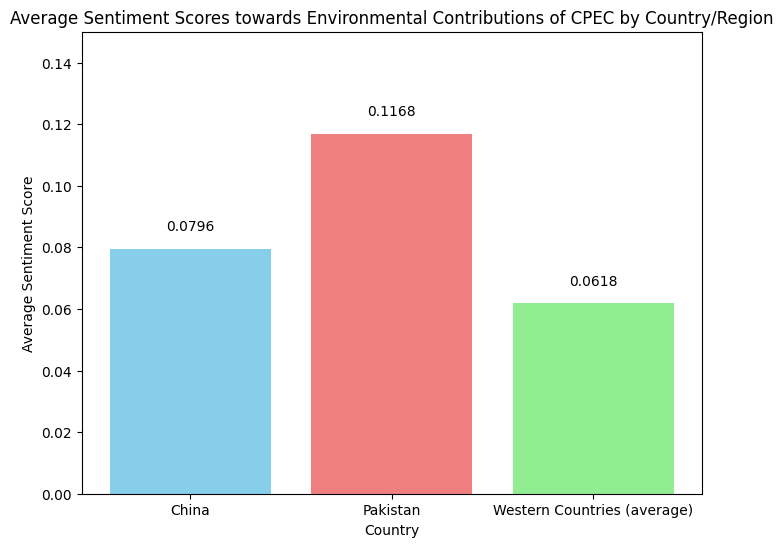

In [ ]:
import matplotlib.pyplot as plt

countries = ['China', 'Pakistan', 'Western Countries (average)']
average_sentiments = [0.07956334325731854, 0.11676049104812321, 0.06181507328639728]

plt.figure(figsize=(8, 6))
bars = plt.bar(countries, average_sentiments, color=['skyblue', 'lightcoral', 'lightgreen']) # Store the bar objects
plt.title('Average Sentiment Scores towards Environmental Contributions of CPEC by Country/Region')
plt.xlabel('Country')
plt.ylabel('Average Sentiment Score')
plt.ylim(0, 0.15)

for bar, sentiment in zip(bars, average_sentiments):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(sentiment, 4), ha='center', va='bottom')

plt.show()
